# Hello World 

### The code on this page was developed using the following requirements. 
### We recommend using these versions or newer.

qiskit[all]~=2.0.0  
qiskit-ibm-runtime~=0.37.0

---

This example contains two parts. You will first create a simple quantum program <br> and run it on a quantum processing unit (QPU).
Because actual quantum research requires much more robust programs, in the second section (Scale to large numbers of qubits), you will cale the simple program uo to utility level.

## Step 1. Map the problem to a quantum native format
In a quantum program, *quantum circuits* are the native format in which to represent quantum instructions, and *operators* represent the   observables to be measured. When creating a circuit, you'll usrally create a new QuantumCircuit   object, then add instructions to it in sequence.

The following code cell creates a circuit that produces a Bell state, which is a state wherein two qubits are fully entangled with each other.

The Qiskit SDK uses the LSb 0 bit numbering where the n<sup>th</sup> digit has value **1** << n or **2**<sup>n</sup>.  


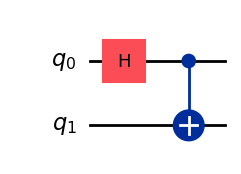

In [3]:
from IPython.display import clear_output

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Creaete a new circuit woth two qubits
qc=QuantumCircuit(2)

#Add a Hadamard gate to qubit 0
qc.h(0)  

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)  

# Return a drawing of the circuit using MatPlotLib ("mpl").
# These guides are written by using Jupyter notebooks, which display the 
# output of the last line of each cell. If you're running this in a script, use 
# `print(qc.draw())` to print a text drawing.
qc.draw(output='mpl') 




This example measures expectation values by using the *qiskit.quantum_info submodule,  which is specified by using operators (mathematical objects used to represent an action or process that changes a quantum state). The following code cell creates six two-qubit Pauli operators: IZ, IX , ZI , XI, ZZ and XX.


In [4]:
# Set up six different observables.

observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp (label) for label in observables_labels]
                      



# Step 2. Optimize the circuits and operators
When executing circuits on a device, it is important to optimize the  
set of instructions that the circuit contains and minimize the overall depth  
(roughly the number of instructions) of the circuit. This ensures that you obtain  
the best results possible by reducing the effects of error and noise.  
Additionally, the circuit's instructions must conform to a backend device's   
*Instruction Set Architecture (ISA)* and must consider the device's basis gates and qubit connectivity.  
The following code instantiates a real device to submit a job to and transforms  
the circuit and observables to match that backend's ISA.  
The following code instantiates a real device to submit a job to and transforms the circuit and observables to match that backend's ISA. It requires that you have already saved your credentials.

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]
Using backend: ibm_sherbrooke


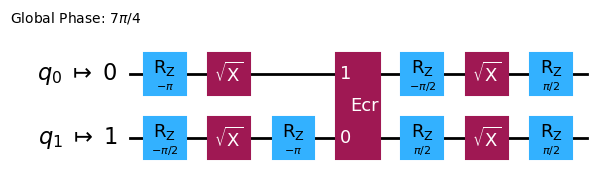

In [5]:
#.   QDcOPHdQw2So98jLrsy7gjR-hnNa6oPDZ4sPHV0bxBW1

from qiskit_ibm_runtime import QiskitRuntimeService 
QiskitRuntimeService.delete_account()

QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="QDcOPHdQw2So98jLrsy7gjR-hnNa6oPDZ4sPHV0bxBW1",
    instance="instance_satya",
    overwrite=True
)

service = QiskitRuntimeService(channel="ibm_cloud")
print(service.backends())

backend = service.least_busy(simulator=False, operational=True)
print(f"Using backend: {backend.name}")

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw("mpl", idle_wires=False)
# clear_output(wait=True)

# Step 3- Execute using the quantum primitives

Quantum computers can produce random results, so you usually collect <br> a sample of the outputs by running the circuit many times. You can estimate the value of the observable by using the *Estimator* class. *Estimator* is one of two *primitives*; the other is *Sampler*, which can be used to get data from a quantum computer. These objects possess a run() method that executes the selection of circuits, observables, and parameters (if applicable), using a *primitive unified bloc (PUB).


In [6]:
# Construct the Estimator instance.
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later. 
print(f">>> Job ID: {job.job_id()}")




>>> Job ID: d1ojfaot0npc73flp030


After the job completes, exampine its output through the job's *result* attribute.

In [7]:
# This is the result of the entire submission. 
# You submitted one Pub, so this contains one inner result (and some matadata of its own).
job_result = job.result()

# This is the result from our single pub, which had six observables,
# so contains information on all six.

pub_result = job.result()[0]



In [8]:
# Check there are six observables.
# If not, edit the comments in the previous cell and update this test.
assert len(pub_result.data.evs) == 6
# Check the first observable is the one we expected.


When you run your quantum program on a real device, your workload must wait   
in a queue before it runs. To save time, you can instead use the following code to 
run this small workload on the 'fake_provider' with the Qiskit Runtime local  
testing mode. Note that this is only possible for a small circuit. When you scale up in the next section, you will need to use a real device.

In [9]:
# Use the following code instead if you want to run on a simulator:

from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
backend = FakeAlmadenV2()
estimator = Estimator(backend)

# Convert to an ISA circuit and layout-mapped observables.

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()

# This is the result of the entire submission.
# You submitted one Pub, so this contains one inner result (and some matadata of its own).
job_result = job.result()

# This is the result from our single pub, which had five observables, 
# so contains information on all five.
pub_result = job.result()[0]


# Step 4. Analyze the results
The analyze step is typically where ou might postprocess your results using, for example, measurement error mitigation or zero noise extrapolation (ZNE).
You night feed these results into another workflow for further analysis or prepare a plot of the key values and daa. In general, this step is specific to tour problem. For this example, plot each of the expectation values that were measured for our circuit.

The expectation values and stadard deviations for the observables you specified to Estimator are accessed through the job result's *PubResult.data.evs and PubResult.data.stds attributes. To obtain the result from Sampler, use the PubResult.data.=meas.get_counts() function, which will return a dict of measurements in the form of bitstrings as keys and counts as their corresponding values. 

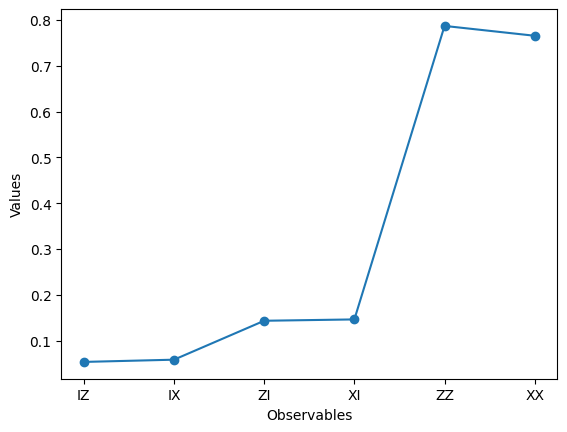

In [10]:
# Plot the results.

from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()


Notice that for qubits 0 and 1, the independent expectation values of both X and Z
  are 0, while the correlations (XX and ZZ) are 1. 
## This is a hallmark of quantum entanglement.

In [15]:
# Make sure the results follow the claim from the previous markdown cell.
# This can happen when the device occasionally behaves strangely. If this
# fails, You may just need to run the notebook again.
_results = {obs: val for obs, val in zip(observables_labels, values)}
for _label in ["IZ", "IX", "ZI", "XI"]:
    assert abs (_results[_label]) < 0.2
for _label in ["XX", "ZZ"]:
    assert _results[_label] > 0.7    